In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["text.usetex"] = False

In [2]:
import time
import string

import emcee
import corner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pymc3 as pm

import theano
import theano.tensor as tt

from rvhmc import RVDataset, PolynomialTrend, RVModel, RVPlanet

In [3]:
def build_model(peaks, t, y=None, yerr=None, model=None):
    model = pm.modelcontext(model)
    
    if yerr is None:
        yerr = np.random.uniform(0.01, 0.1, len(t))
    if y is None:
        y = yerr*np.random.randn(len(t))
        
    trend = PolynomialTrend("trend", order=3)
    logs = pm.Normal("logs", mu=-5.0, sd=5.0, testval=-5.0)
    meanrv = pm.Normal("meanrv", mu=0.0, sd=10.0, testval=0.0)
    dataset = RVDataset("data", t, y, yerr, logs=logs, trend=trend)
    
    logamps = pm.Uniform("logamps",
                         lower=np.log(min_amp),
                         upper=np.log(max_amp),
                         shape=n_planets,
                         testval=np.log([np.clip(peak["amp"],
                                                 min_amp+1e-2,
                                                 max_amp-1e-2)
                                         for peak in peaks]))
    
    planets = []
    for i, (peak, name) in enumerate(zip(peaks, string.ascii_lowercase[1:])):
        logP = pm.Uniform(name + ":logP",
                          lower=np.log(min_period),
                          upper=np.log(max_period),
                          testval=np.log(peak["period"]))
        logK = pm.Deterministic(name + ":logK", logamps[i])

        eccen = pm.Beta(name + ":eccen",
                        alpha=0.867,
                        beta=3.03,
                        testval=0.3)
        omegabase = pm.Uniform(name + ":omegabase", -2*np.pi, 2*np.pi, testval=0.0)
        omegavec = pm.Deterministic(name + ":omegavec", tt.stack([tt.cos(omegabase), tt.sin(omegabase)]))

        phibase = pm.Uniform(name + ":phibase", -2*np.pi, 2*np.pi, testval=peak["phase"])
        phivec = pm.Deterministic(name + ":phivec", tt.stack([tt.cos(phibase), tt.sin(phibase)]))
        planets.append(
            RVPlanet(name, logP, logK, phivec=phivec, eccen=eccen, omegavec=omegavec))

    rvmodel = RVModel("rv", dataset, planets)
    pm.Deterministic("logp", model.logpt)
    
    return rvmodel

In [4]:
np.random.seed(42)
n_planets = 1

t = np.sort(np.random.uniform(0.0, 4*365.0, 50))
yerr = np.random.uniform(0.01, 0.1, len(t))
y = yerr * np.random.randn(len(t))

min_period = 5
max_period = 100
min_amp = 0.2
max_amp = 0.8
target_n_eff = 500

peaks = []
for i in range(n_planets):
    peaks.append(dict(
        period=np.exp(np.random.uniform(np.log(min_period), np.log(max_period))),
        amp=np.exp(np.random.uniform(np.log(min_amp), np.log(max_amp))),
        phase=np.random.uniform(0, 2*np.pi),
    ))
peaks = sorted(peaks, key=lambda x: x["amp"])

with pm.Model() as sim_model:
    sim_rvmodel = build_model(peaks, t, y, yerr)
    f = theano.function(sim_model.vars, sim_rvmodel.get_rvmodels(t), on_unused_input='ignore')
    coords = sim_model.test_point
    y += np.sum(f(*(coords[k.name] for k in sim_model.vars)), axis=1)

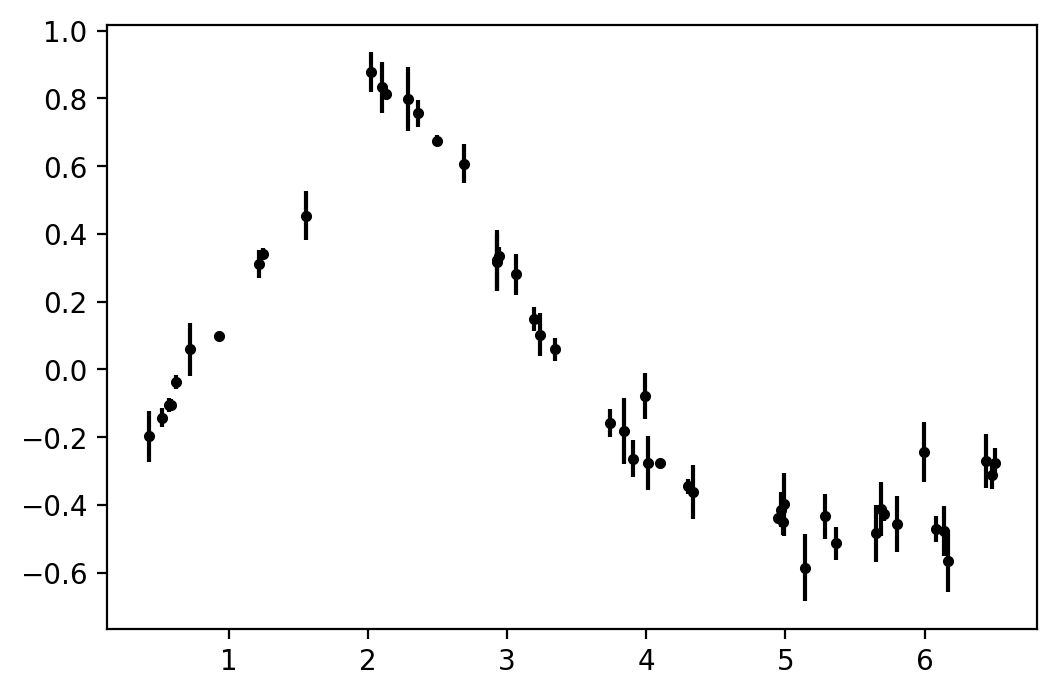

In [5]:
plt.errorbar(t % peaks[-1]["period"], y, yerr=yerr, fmt=".k");

In [6]:
with pm.Model() as model:
    rvmodel = build_model(peaks, t, y, yerr)
    
    key_vars = [v.name for v in rvmodel.datasets[0].vars]
    key_vars += [p.name + k for p in rvmodel.planets for k in (":logP", ":logK", ":phi", ":eccen", ":omega")]

In [7]:
with model:
    f = theano.function(model.vars, [model.logpt] + model.vars + model.deterministics)
    
    def log_prob_func(params):
        dct = model.bijection.rmap(params)
        args = (dct[k.name] for k in model.vars)
        results = f(*args)
        return tuple(results)

    # First we work out the shapes of all of the deterministic variables
    res = model.test_point
    vec = model.bijection.map(res)
    initial_blobs = log_prob_func(vec)[1:]
    dtype = [(var.name, float, np.shape(b)) for var, b in zip(model.vars + model.deterministics, initial_blobs)]
    
    # Then sample as usual
    coords = vec + 1e-5 * np.random.randn(3*len(vec), len(vec))
    nwalkers, ndim = coords.shape
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_func, blobs_dtype=dtype)
    thin_by = 100
    
    tottime = 0
    for i in range(1000):
        strt = time.time()
        sampler.run_mcmc(coords, 50, thin_by=thin_by, progress=True)
        tottime += time.time() - strt
        tau = sampler.get_autocorr_time(quiet=True)
        print(sampler.iteration * nwalkers / tau)
        converged = np.all(tau * target_n_eff / thin_by < sampler.iteration * nwalkers)
        converged &= np.all(sampler.iteration > 50 * tau)
        if converged:
            break
    tau_emcee = np.copy(tau)
    time_emcee = tottime
    time_per_emcee = time_emcee / (sampler.iteration * nwalkers)
    time_ind_emcee = time_per_emcee * tau_emcee

100%|██████████| 5000/5000 [00:22<00:00, 219.82it/s]
N/50 = 1;
tau: [1.15809913 0.98817939 1.30072599 1.04565423 1.13929733 1.22496962
 1.5032929  1.11614816 1.09750226]
  0%|          | 19/5000 [00:00<00:26, 184.63it/s]

[1165.70331942 1366.1487157  1037.88192648 1291.05775157 1184.94089937
 1102.06814944  898.02858932 1209.51684496 1230.06580076]


100%|██████████| 5000/5000 [00:22<00:00, 219.20it/s]

[2159.96401087 2483.53807685 1940.37109057 2071.13781134 1925.59978075
 2054.77086598 1860.59684071 1933.1840128  1934.57167825]


In [8]:
time_ind_emcee

array([0.02109932, 0.01835034, 0.02348714, 0.02200422, 0.02366731,
       0.02217949, 0.02449416, 0.02357446, 0.02355755])

In [9]:
with model:
    start = model.test_point
    
    ntune = 2000
    samples = sampler.get_chain(discard=int(tau_emcee.max()), flat=True)
    potential = pm.step_methods.hmc.quadpotential.QuadPotentialFull(
        np.cov(samples, rowvar=0))
    step = pm.NUTS(potential=potential)
    
#     ntune = 5000
#     _, step = pm.init_nuts(init="adapt_diag", target_accept=0.8)
    
    print("Running burn-in...")
    burnin = pm.sample(start=start, tune=ntune, draws=1, step=step, chains=1,
                       compute_convergence_checks=False)
    
    trace = None
    next_start = burnin.point(-1)
    draws = 2000
    chains = 2
    ntotal = 0
    tottime = 0
    for i in range(100):
        strt = time.time()
        trace = pm.sample(start=next_start, trace=trace, tune=0, draws=draws, step=step, chains=chains,
                          compute_convergence_checks=False, cores=1)
        tottime += time.time() - strt
        ntotal += draws * chains
        next_start = [trace.point(-1, c) for c in trace.chains]

        tau = np.array([float(emcee.autocorr.integrated_time(np.array(trace.get_values(v, combine=False)).T,
                                                             quiet=True))
                        for v in key_vars])
        print(tau)
        print(ntotal / tau)
        print(pm.summary(trace, varnames=key_vars).n_eff)
        
        if (ntotal / tau).min() > target_n_eff and ntotal > tau.max() * 50:
            break
    tau_pymc = np.copy(tau)
    time_pymc = tottime
    time_per_pymc = time_pymc / (len(trace) * chains)
    time_ind_pymc = time_per_pymc * tau_pymc

Only 1 samples in chain.
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [b:phibase, b:omegabase, b:eccen, b:logP, logamps, meanrv, logs, trend:d2vdt2, trend:d1vdt1]
INFO:pymc3:NUTS: [b:phibase, b:omegabase, b:eccen, b:logP, logamps, meanrv, logs, trend:d2vdt2, trend:d1vdt1]
  0%|          | 0/2001 [00:00<?, ?it/s]

Running burn-in...


100%|██████████| 2001/2001 [00:10<00:00, 197.76it/s]
Sequential sampling (2 chains in 1 job)
INFO:pymc3:Sequential sampling (2 chains in 1 job)
NUTS: [b:phibase, b:omegabase, b:eccen, b:logP, logamps, meanrv, logs, trend:d2vdt2, trend:d1vdt1]
INFO:pymc3:NUTS: [b:phibase, b:omegabase, b:eccen, b:logP, logamps, meanrv, logs, trend:d2vdt2, trend:d1vdt1]
100%|██████████| 2000/2000 [00:08<00:00, 229.69it/s]
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 22 divergences after tuning. Increase `target_accept` or reparameterize.


[2.07740473 1.64275039 1.50792609 1.46849315 1.37800533 1.54880418
 1.37121161 1.30807551]
[1925.47939706 2434.94082921 2652.64991112 2723.88060413 2902.74638363
 2582.63765105 2917.12816588 3057.92743379]
logs            1770.548324
trend:d1vdt1    2602.538280
trend:d2vdt2    2950.860521
b:logP          2726.112185
b:logK          2840.086192
b:phi           2594.484616
b:eccen         2881.418048
b:omega         2993.223027
Name: n_eff, dtype: float64


In [10]:
time_ind_pymc, time_ind_emcee

(array([0.00960304, 0.0075938 , 0.00697056, 0.00678827, 0.00636998,
        0.00715952, 0.00633858, 0.00604673]),
 array([0.02109932, 0.01835034, 0.02348714, 0.02200422, 0.02366731,
        0.02217949, 0.02449416, 0.02357446, 0.02355755]))

In [11]:
time_ind_pymc, time_ind_emcee

(array([0.00960304, 0.0075938 , 0.00697056, 0.00678827, 0.00636998,
        0.00715952, 0.00633858, 0.00604673]),
 array([0.02109932, 0.01835034, 0.02348714, 0.02200422, 0.02366731,
        0.02217949, 0.02449416, 0.02357446, 0.02355755]))

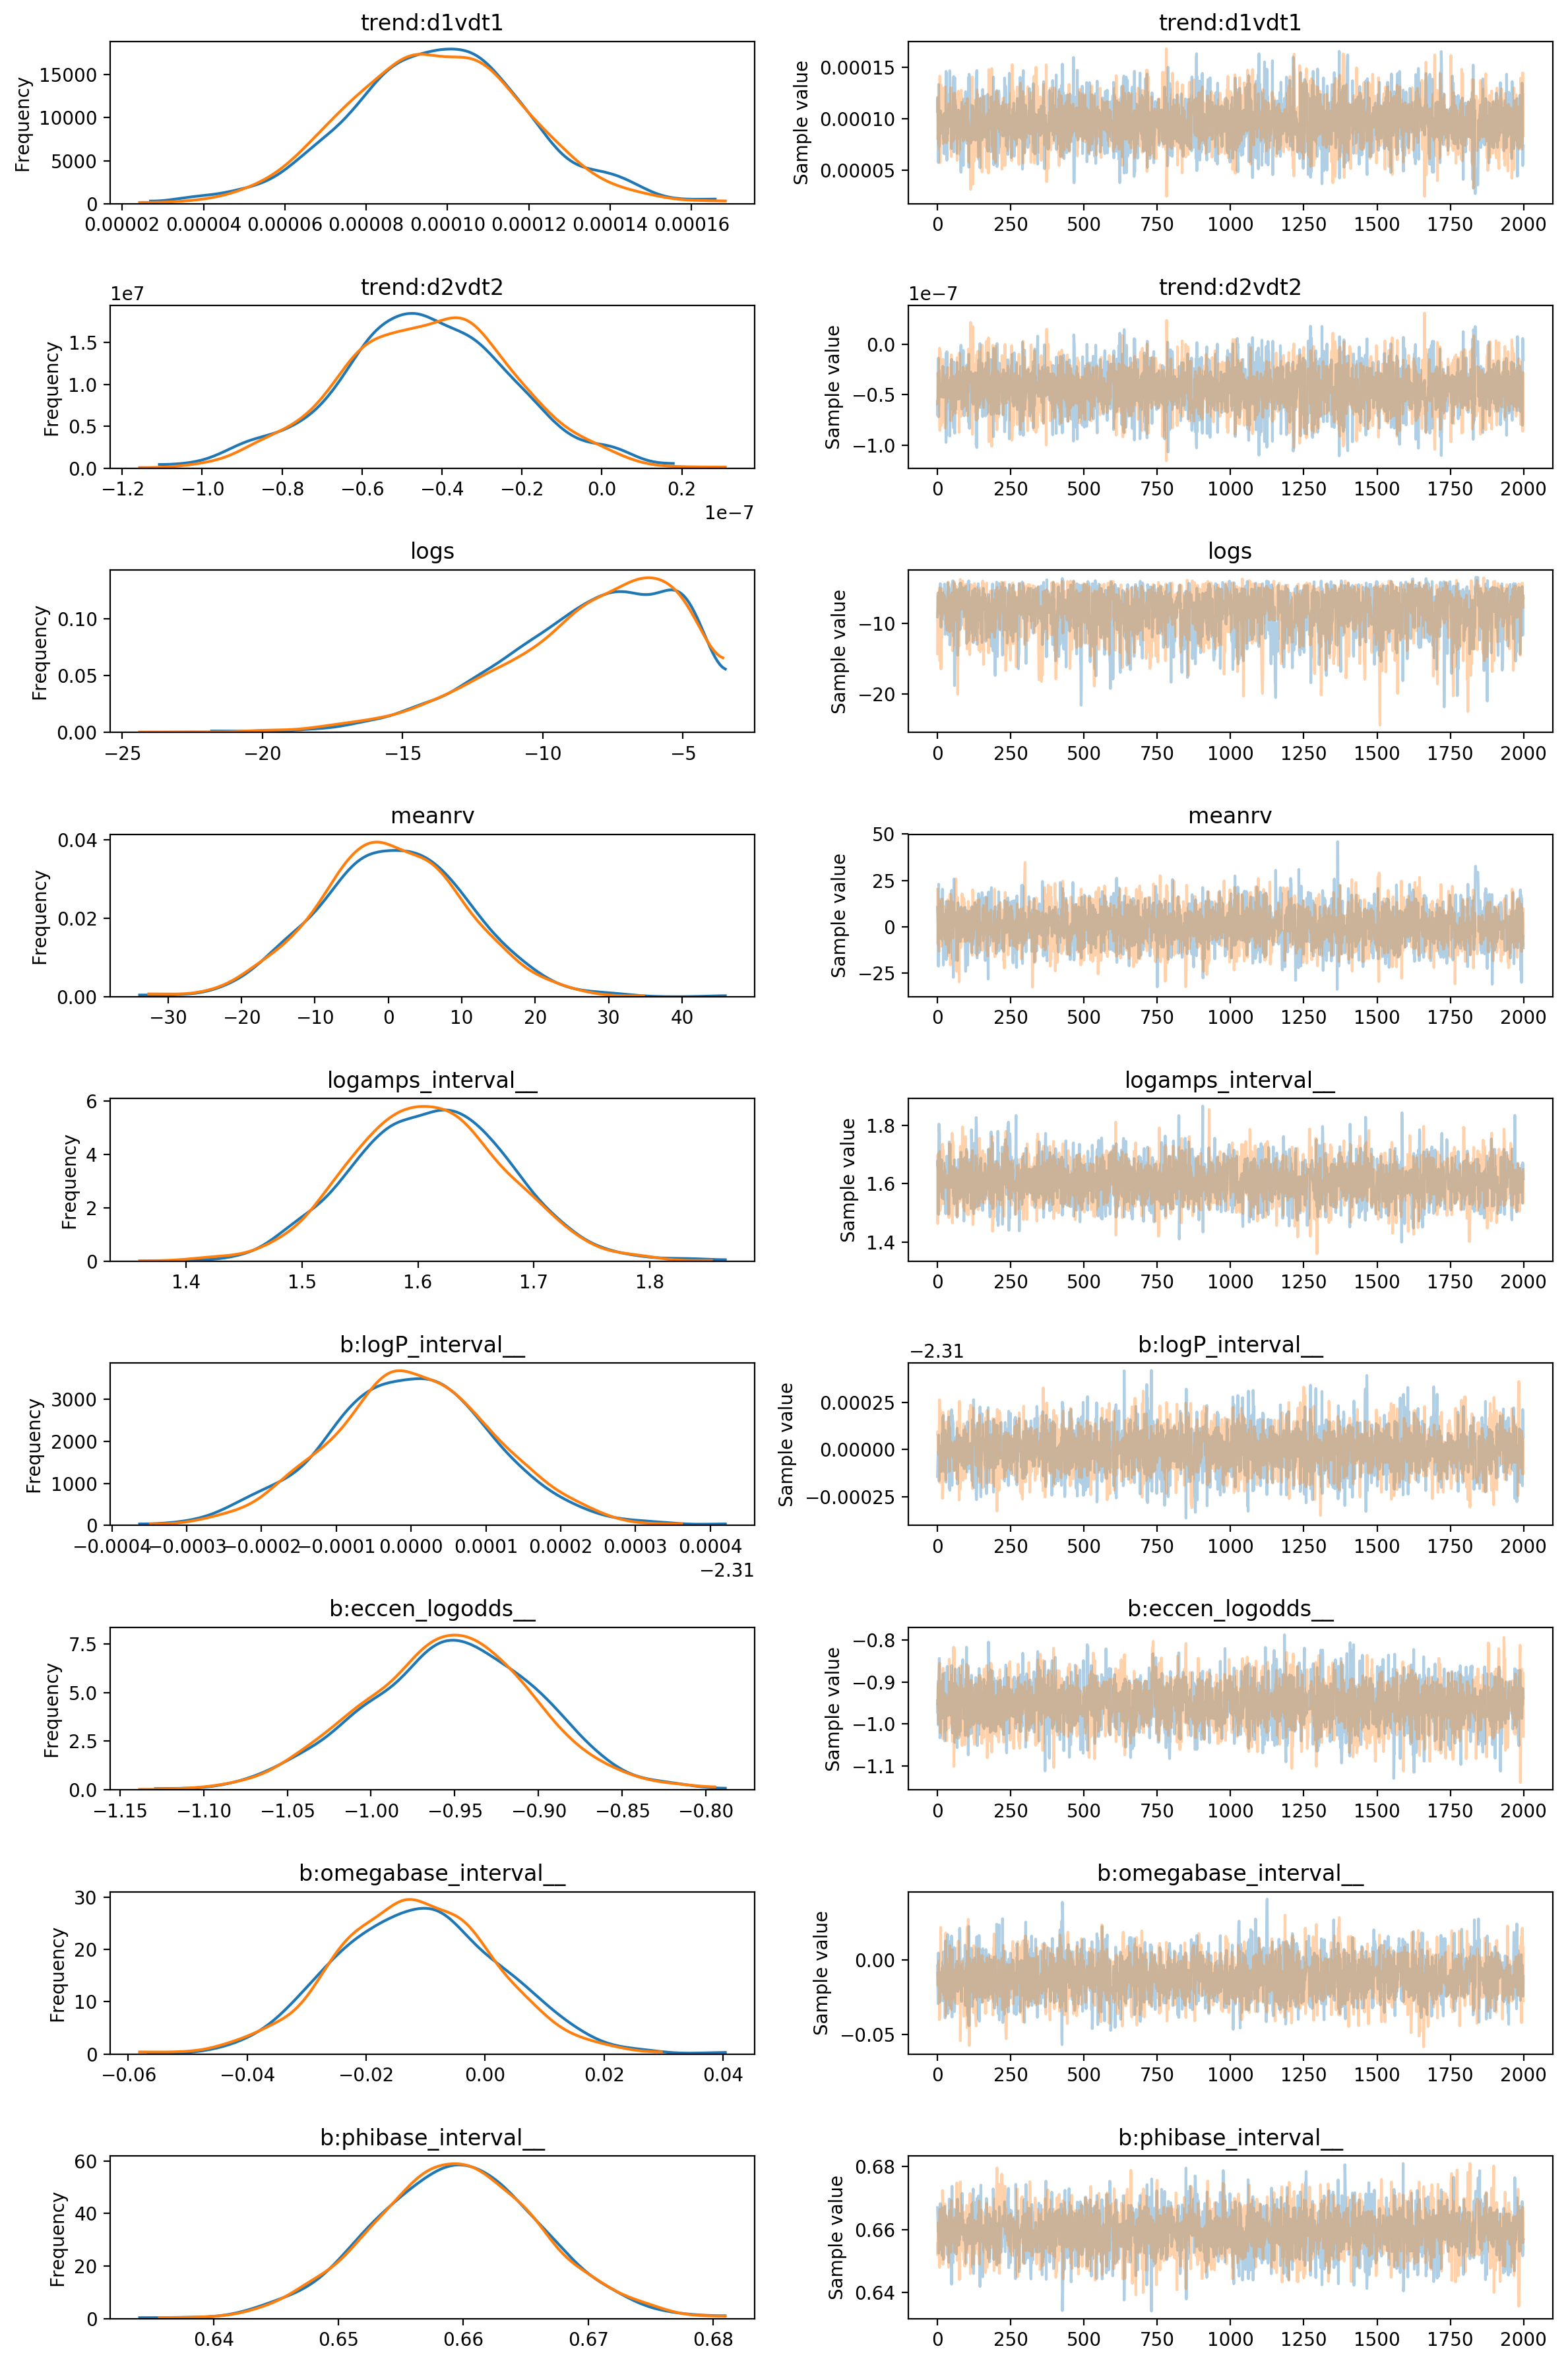

In [12]:
pm.traceplot(trace, varnames=[v.name for v in model.vars]);

In [13]:
pm.summary(trace, varnames=[v.name for v in model.vars])

mean            sd      mc_error  \
trend:d1vdt1            9.706928e-05  2.170192e-05  3.840284e-07   
trend:d2vdt2           -4.442573e-08  2.136076e-08  3.589461e-10   
logs                   -8.454519e+00  3.132054e+00  7.044871e-02   
meanrv                  4.152523e-01  9.924842e+00  1.923383e-01   
logamps_interval____0   1.609459e+00  6.591425e-02  1.205270e-03   
b:logP_interval__      -2.310001e+00  1.094506e-04  2.145706e-06   
b:eccen_logodds__      -9.534164e-01  5.086383e-02  9.386093e-04   
b:omegabase_interval__ -1.173971e-02  1.332881e-02  2.503220e-04   
b:phibase_interval__    6.592994e-01  6.648429e-03  1.412391e-04   

                             hpd_2.5      hpd_97.5        n_eff      Rhat  
trend:d1vdt1            5.568321e-05  1.421445e-04  2602.538280  1.000150  
trend:d2vdt2           -8.829533e-08 -2.460389e-09  2950.860521  1.000138  
logs                   -1.459786e+01 -3.950463e+00  1770.548324  0.999750  
meanrv                 -1.875731e+01  1.917014e+01  2533.984627  1.000523  
logamps_interval____0   1.484340e+00  1.736895e+00  2813.814641  1.000884  
b:logP_interval__      -2.310225e+00 -2.309792e+00  2726.041599  1.000425  
b:eccen_logodds__      -1.054665e+00 -8.574054e-01  2870.065237  1.000615  
b:omegabase_interval__ -3.688577e-02  1.478359e-02  2993.274657  1.000695  
b:phibase_interval__    6.463137e-01  6.723877e-01  2593.001383  0.999755

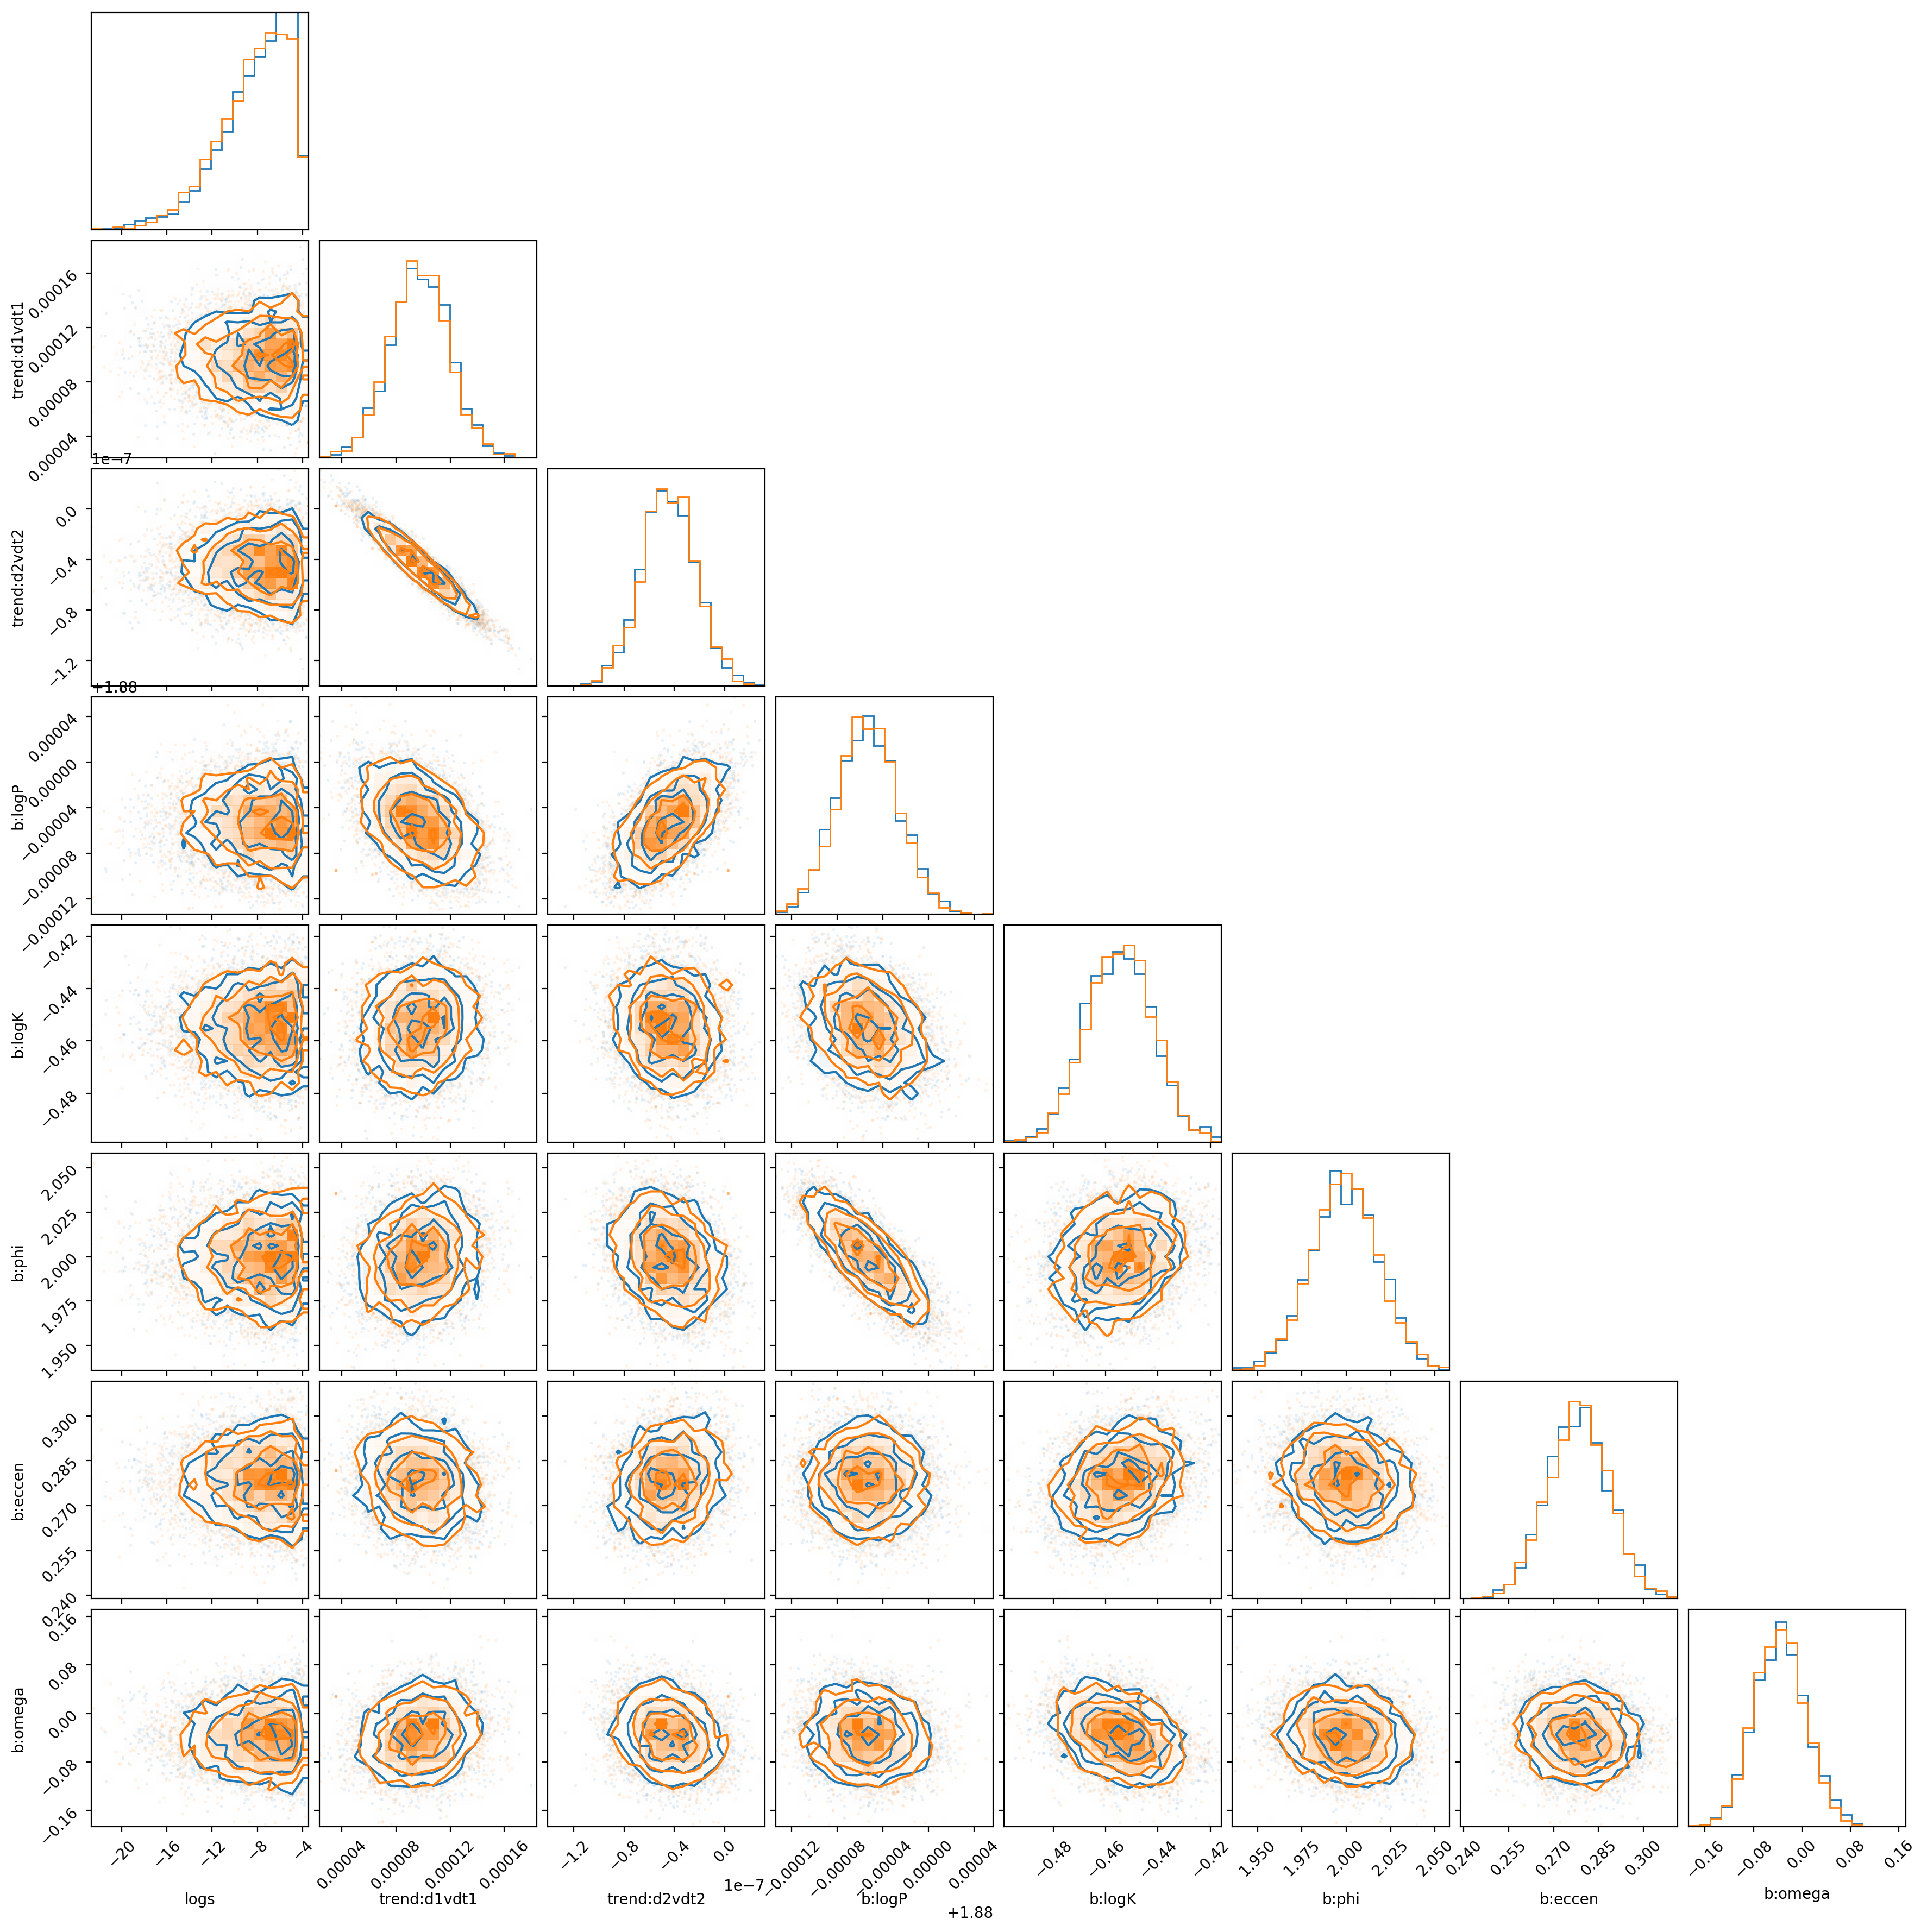

In [14]:
tau = sampler.get_autocorr_time().max()
samples = sampler.get_blobs(flat=True, discard=int(2*tau), thin=int(tau))
df_emcee = pd.DataFrame.from_records(samples[key_vars])

ranges = [(np.min(df_emcee[k]), np.max(df_emcee[k])) for k in df_emcee.columns]

df_pymc = pm.trace_to_dataframe(trace, varnames=key_vars)

w_pymc = len(df_emcee) / len(df_pymc) + np.zeros(len(df_pymc))

v = key_vars[:15]
fig = corner.corner(df_emcee[v], color="C0",
                    range=ranges[:len(v)])
corner.corner(df_pymc[v], weights=w_pymc, color="C1", fig=fig,
              range=ranges[:len(v)]);

In [19]:
samples = sampler.get_blobs()[key_vars]
np.array([float(emcee.autocorr.integrated_time(samples[k])) for k in key_vars])

array([1.45114726, 1.39565777, 1.39665959, 1.30363833, 1.39308981,
       1.25008389, 1.39031965, 1.08715852])